<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Classification with K-Nearest Neighbors

_Authors: Kiefer Katovich (SF), Alexander Barriga (SF), Joseph Nelson (DC)_

---

### Learning Objectives
- Understand the difference between classification and regression models
- Understand the K-Nearest Neighbors algorithm visually and in pseudocode
- Explain the differences between distance metrics and explore the two most common
- Apply KNN classification to the Wisconsin breast cancer dataset
- Practice manually performing stratified cross-validation
- Visually examine the effect of K neighbors on the decision boundary
- Explain the effect of choosing K on the bias-variance tradeoff

### Lesson Guide
- [Introduction: Classification vs. Regression](#intro)
- [K-nearest Neighbors, Visually](#knn-visual-intro)
- [The K-Nearest Neighbors (KNN) Algorithm](#knn)
    - [A Note on Parametric vs. Nonparametric Methods](#nonparametric)
- [The KNN Distance Metric](#distance)
    - [Euclidean Distance](#euclidean)
    - [Manhattan Distance](#manhattan)
- [Load the Wisconsin Breast Cancer Data Set](#wisconsin)
    - [Rename Columns and Subset the Data](#rename-subset)
    - [Encode the Target as a Binary Class](#target)
- [Examine the Correlation Structure of the Data Set](#correlations)
    - [Use a Heatmap](#heatmap)
    - [Use a Pairplot](#pairplot)
- [Using Scikit-Learn's `KNeighborsClassifier` and `StratifiedKFold`](#kneighborsclassifier)
    - [Create the Target and Predictors](#target-predictors)
    - [Standardize the Predictor Matrix](#standardize)
    - [Write a Function to Manually Perform the Cross-Validation Procedure](#manual-cv)
    - [Calculate the "Baseline" Accuracy](#baseline)
    - [Cross-Validate the Mean Accuracy With Five Neighbors](#cv-knn5)
    - [Cross-Validate the Mean Accuracy with One Neighbor](#cv-knn5)
- [Visualize the KNN Decision Boundary](#visualize-knn)
- [How is Bias-Variance Affected by the Number of Neighbors?](#bias-variance)
- [Additional Resources](#resources)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='intro'></a>
## Introduction: Regression vs. Classification

We've discussed the difference between continuous and discrete numbers. We've predicted continuous numbers using regression. But what about discrete numbers?

Think back to the wine quality data set we've used in the past. We used linear regression to predict the quality on a zero–10 scale. What if we just wanted to predict whether wine was good or bad? Red or white? 

Classification algorithms do just that — they predict categories or classes. They split the data into groups and place new data into those groups. 

![](http://ipython-books.github.io/images/ml.png "Best Split vs Best Fit")

<a id='knn-visual-intro'></a>

---

### K-Nearest Neighbors (KNN), Visually

**KNN works similarly to how we humans might choose to classify things. Below we have some red and blue dots:**
![Alt text](http://blog.yhat.com/static/img/knn_reds_and_blues.png "Some Dots")

**A new dot appears without a color and we need to decide which color it is most likely going to be.**
![Alt text](http://blog.yhat.com/static/img/knn_new_point.png "A New Dot Appears")

**We compare it to its three nearest neighbors – its neighbors are more often red, so we label it red.**
![Alt text](http://blog.yhat.com/static/img/knn_new_point_pred.png "3 Nearest Neighbors")

**What if we increase the number of neighbors to consider to 5?**
![Alt text](http://blog.yhat.com/static/img/knn_new_point_pred_blue.png "5 Nearest Neighbors")

**This is in essence the K-Nearest Neighbors (KNN) algorithm. The K represents the number of "neighbors" you use.**

> ***Images above credited to the [yhat blog](http://blog.yhat.com/).***

<a id='knn'></a>

## The KNN Algorithm

---

K-Nearest Neighbors takes a different approach to modeling than we have been practicing with linear models. In order to estimate a value (regression) or class membership (classification), the algorithm finds the observations in its training data that are "nearest" to the observation to predict. It then averages or takes a vote of those training observations' target values to estimate the value for the new data point.

Distance is usually calculated using the euclidean distance. The "K" in KNN refers to the number of nearest neighbors that will be contributing to the prediction. 

Today we will be looking at KNN only in the context of classification.

**The KNN can be concisely represented with pseudocode:**

```
for unclassified_point in sample:
    for known_point in known_class_points:
        calculate distances (euclidean or other) between known_point and unclassified_point
    for k in range of specified_neighbors_number:
        find k_nearest_points in known_class_points to unclassified_point
    assign class to unclassified_point using "votes" from k_nearest_points
```

> **Note**: in the case of ties, sklearn's `KNeighborsClassifier()` will just choose the first class (when weights are uniform)! If this is unappealing to you you can change the weights keyword argument to 'distance'. More on this later.  Additionally, choosing an appropriate `K`, such as an odd number when there are an even number of classes or setting `K` as a prime number, can help avoid ties.



---

<a id='nonparametric'></a>

### Note on Parametric vs. Nonparametric Methods

Thus far, all of our tests and methods have been **parametric**. That is, we have _assumed a certain distribution_ for our data. In linear regression our parameters are the coefficients in our model, and our estimate of the target is calculated from these parameters.

There are alternatives in the case where we cannot assume a particular distribution for our data or choose not to. These methods are **nonparametric**. When we make _no assumptions about the distribution_ for our data, we call our data nonparametric. For nearly every parametric test, there is a nonparametric analog available. The KNN model is an example of a nonparametric model. You can see that there are no coefficients for the different predictors and our estimate is not represented by a formula of our predictor variables.

<a id='distance'></a>
## The KNN Distance Metric

---
KNN typically uses one of two distance metrics: **euclidean** ('yoo-klid-ee-uhn') or **manhattan**. Other distance metrics are possible, but more rare (sometimes it makes sense to create your own distance function.

<a id='euclidean'></a>
### Euclidean Distance

Recal the famous Pythagorean Theorem
![Alt text](http://ncalculators.com/images/pythagoras-theorem.gif)

We can apply the theorem to calculate distance between points. This is called Euclidean distance. 

![Alt text](http://rosalind.info/media/Euclidean_distance.png)

### $$\text{Euclidean  distance}=\sqrt{(x_1-x_2)^2+(y_1-y_1)^2}$$

There are many different distance metrics, but Euclidean is the most common (and default in sklearn).


---

<a id='manhattan'></a>
### Manhattan distance (Taxicab Distance)

Another way to measure distance between two points is to take the sum of the absolute value of their differences. 

### $$ D = \sum_{i=1}^n | x_i - y_i | $$

The name Manhattan distance comes from the fact that taxicabs in Manhattan must drive from point A to point B on streets that force traffic to flow forward or backwards and left or right -- but never diagonally. 
![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Manhattan_distance_bgiu.png/261px-Manhattan_distance_bgiu.png)
![](https://pbs.twimg.com/media/CgIlqLTWEAAedKB.jpg)

**Note that the Manhattan distance is a less common choice.**
- Manhattan distance is more restrictive than Euclidean distance in how distance is measured
- [Manhattan distance comes from $L_{p = 1}$ space and Euclidean distance comes from $L_{p = 2}$ space.](https://en.wikipedia.org/wiki/Lp_space)
- In practice, we can cross-validate KNN using both types of distances to see which performs best. 

![](http://www.improvedoutcomes.com/docs/WebSiteDocs/image/diagram_euclidean_manhattan_distance_metrics.gif)

<a id='wisconsin'></a>

## Load the Wisconsin breast cancer dataset

---

Below we will be testing out the KNN classification algorithm on the classic [Wisconsin breast cancer dataset](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)
> **Note:** (The file as suffix '.data' but is actually formatted as a .csv)

In [2]:
bcw = pd.read_csv('../datasets/wdbc.data', header=None, index_col=None)

---

<a id='rename-subset'></a>
### Rename Columns and Subset the Data

The attributes below are the columns of the dataset.

The column names are taken from the dataset info file. For more information check out the information file:

`../assets/datasets/wdbc.names`

You can open it with a text editor of your choice.

      Attribute                     
    --------------------------------------------
    1. Sample code number [subject ID]
    2. Class
    3. Cell nucleus mean radius
    4. Cell nucleus SE radius
    5. Cell nucleus worst radius
    6. Texture mean
    7. Texture SE
    8. Texture worst
    9. Perimeter mean
    10. Perimeter SE
    11. Perimeter worst
    12. Area mean
    13. Area SE
    14. Area worst
    15. Smoothness mean
    16. Smoothness SE
    17. Smoothness worst
    18. Compactness mean
    19. Compactness SE
    20. Compactness worst
    21. Concavity mean
    22. Concavity SE
    23. Concavity worst
    24. Concave points mean
    25. Concave points SE
    26. Concave points worst
    27. Symmetry mean
    28. Symmetry SE
    29. Symmetry worst
    30. Fractal dimension mean
    31. Fractal dimension SE
    32. Fractal dimension worst
   
**Using the provided list, reassign the column names in the dataset.**

In [3]:
column_names = ['id','malignant',
                'nucleus_mean','nucleus_se','nucleus_worst',
                'texture_mean','texture_se','texture_worst',
                'perimeter_mean','perimeter_se','perimeter_worst',
                'area_mean','area_se','area_worst',
                'smoothness_mean','smoothness_se','smoothness_worst',
                'compactness_mean','compactness_se','compactness_worst',
                'concavity_mean','concavity_se','concavity_worst',
                'concave_pts_mean','concave_pts_se','concave_pts_worst',
                'symmetry_mean','symmetry_se','symmetry_worst',
                'fractal_dim_mean','fractal_dim_se','fractal_dim_worst']

bcw.columns = column_names

**Remove the columns pertaining to the standard deviation and "worst" measurements, leaving only the mean measurement columns.**

In [4]:
bcw = bcw[[c for c in bcw.columns if not '_worst' in c and not '_se' in c]]
bcw.head(2)

,id,malignant,nucleus_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_pts_mean,symmetry_mean,fractal_dim_mean
0,842302,M,17.99,1001.0,0.3001,0.07871,8.589,0.04904,0.03003,17.33,0.1622,0.2654
1,842517,M,20.57,1326.0,0.0869,0.05667,3.398,0.01308,0.01389,23.41,0.1238,0.1860


---
<a id='target'></a>
### Encode the target class variable `malignant` to be a binary 0 vs. 1

The `malignant` class target variable is coded as "B" for benign and "M" as malignant. 

We need to recode this to a binary integer for classification:
 - Encode malign as 1
 - Encode benign as 0
 
Malign is assigned to 1 because our goal is to predict malign tumors with the data. In binary classification problems the category "of interest" to predict is typically encoded as 1.

In [5]:
bcw['malignant'] = bcw['malignant'].map(lambda x: 0 if x == "B" else 1)

In [6]:
print(bcw['malignant'].value_counts())

0    357
1    212
Name: malignant, dtype: int64


<a id='correlations'></a>
## Examine the Correlation Structure of the Dataset

---

You should exclude the `id` column as this is just an indicator variable for the subject.

<a id='heatmap'></a>
### Method 1: Plot a heatmap of the correlation matrix

Plot a seaborn heatmap of the correlation matrix to visually examine which variables are correlated and anti-correlated, and to what degree.

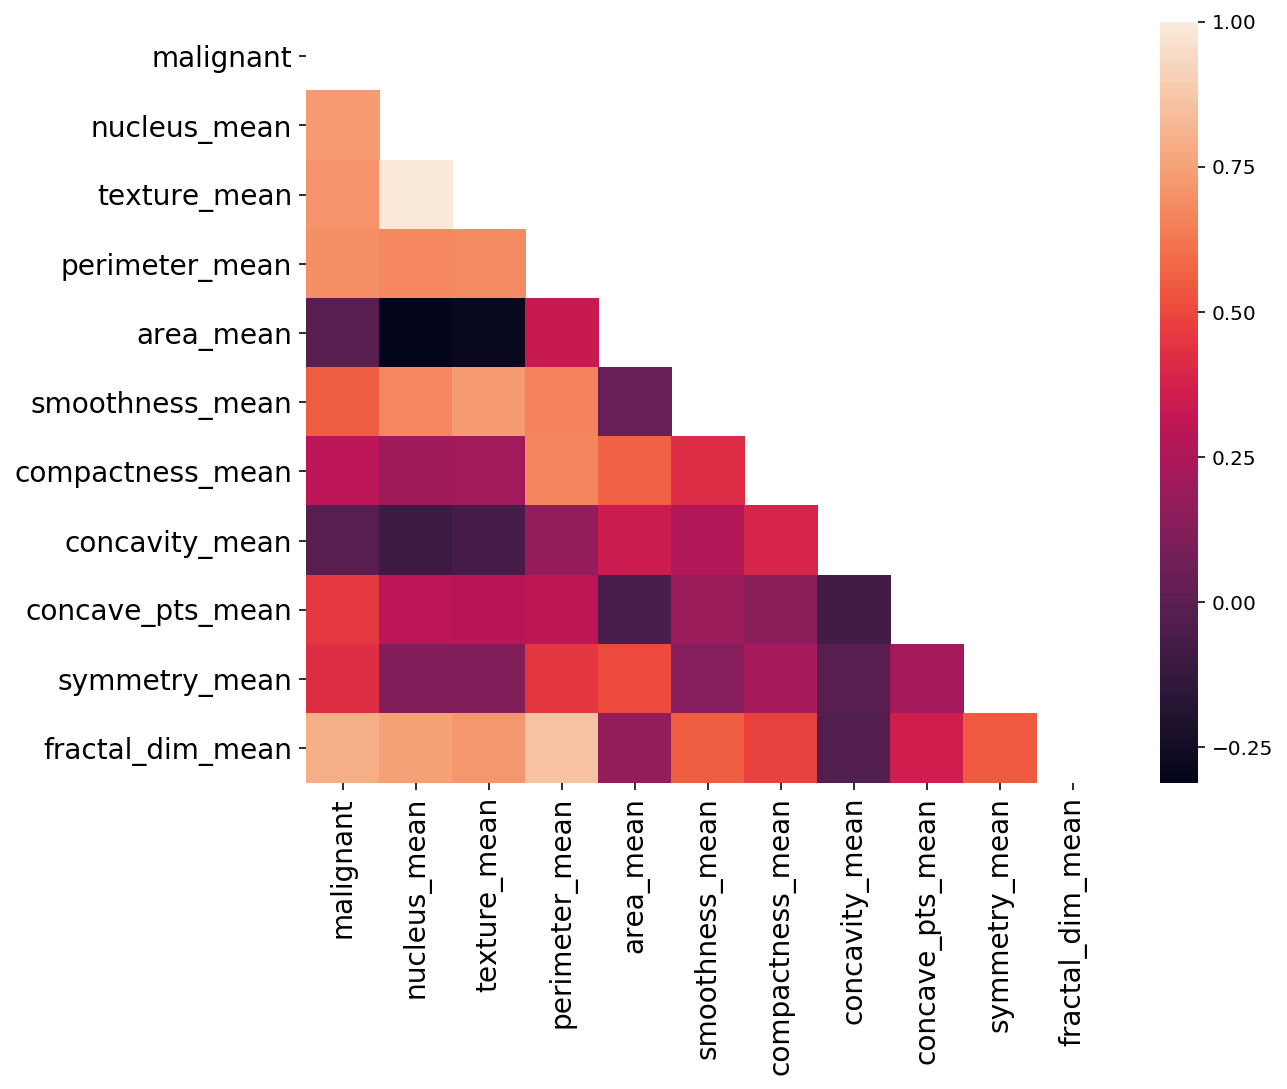

In [7]:
mean_corr = bcw.drop('id', axis=1).corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(9,7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(mean_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(mean_corr, mask=mask, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

<a id='pairplot'></a>
### Method 2: Use seaborn's pairplot to visualize relationships between variables

When you have a small number of predictor variables, seaborn's `pairplot` function will give you a more detailed visual look at the relationships between variables. The pairplot is similar to a correlation matrix, but displays scatterplots of variable pairs. Along the diagonal line are histograms showing the distribution of each variable.

One of the most appealing aspects of the pairplot function for classification tasks is that the scatterplots and histograms can be split along a hue variable. If we use the `malignant` target class as the hue we are able to see how the classes are distributed across these variables as well.

Plot data using seaborn's `pairplot()` function. The hue will be the class variable "malignant". The variables will be the other columns excluding, of course, the subject ID column. This function can take some time to run.

> **Note:** Most of these predictors are highly correlated with the "class" variable. This is already an indication that our classifier is very likely to perform well.

In [8]:
# set the seaborn style to have a white background
sns.set(style="ticks", color_codes=True)

# This function does a pairplot across your variables with the color
# set as the outcome "malignant" class variable
def bcw_pairplotter(df, variables, sample_frac=0.3):
    # sample_frac lets you specify an amount of the data to sample for the plot.
    # this speeds up the function which can take awhile with the full data.
    
    # get the number of rows/data points:
    rows = df.shape[0]
    
    # get downsample indicies for the data, if specified
    if sample_frac < 1.0:
        sample_inds = np.random.choice(range(0,rows), 
                                       size=int(round(rows*sample_frac)), 
                                       replace=False).astype(int)
    
    # make the pairplot for the variables:
    pairs = sns.pairplot(df.iloc[sample_inds, :], 
                         vars=variables, 
                         hue="malignant", 
                         palette=sns.xkcd_palette(['windows blue', 'amber']))

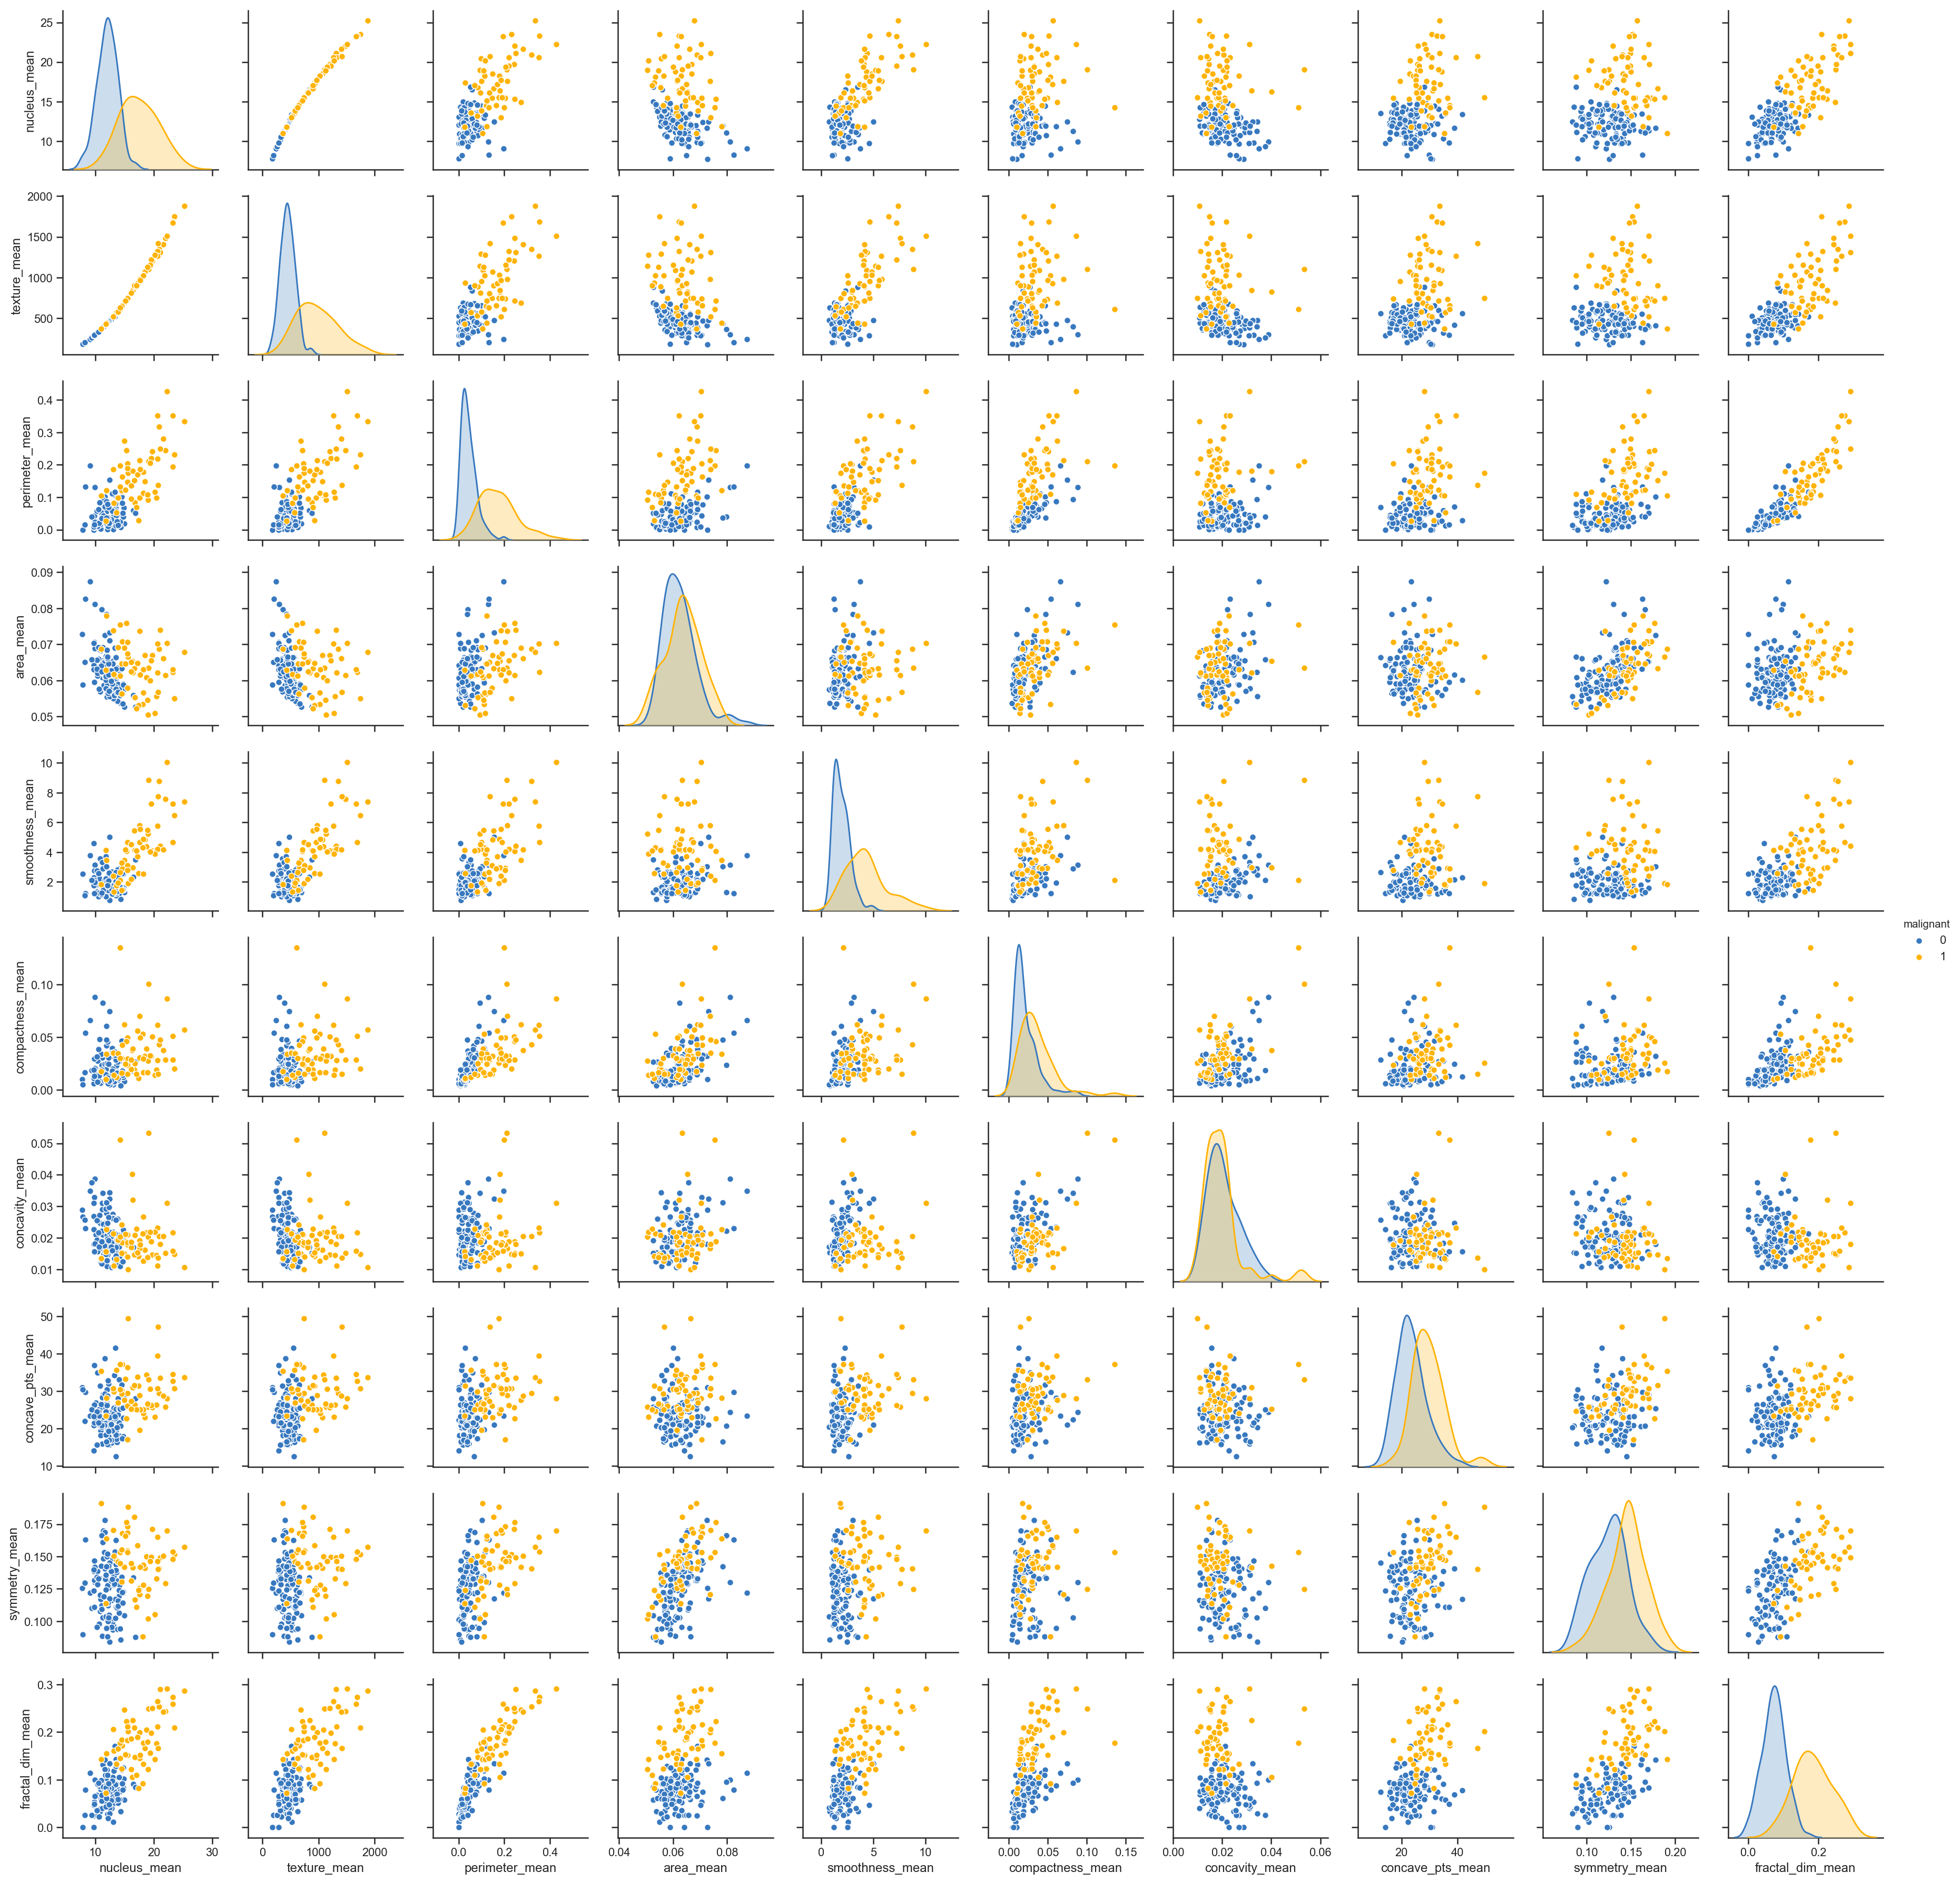

In [9]:
# get out the column variable names to put into the pairplotter function
colvars = [x for x in bcw if x not in ['id','malignant']]
bcw_pairplotter(bcw, colvars)

<a id='kneighborsclassifier'></a>

## Using sklearn's `KNeighborsClassifier` and `StratifiedKFold`

---

Let's see how the sklearn KNN classifier performs on our dataset predicting the malignant target class using cross-validation.

Load the KNN classifier like so:
```python
from sklearn.neighbors import KNeighborsClassifier
```

**We are going to set some arguments when instantiating the model:**
1. **n_neighbors** specifies how many neighbors will vote on the class
2. **weights** uniform weights indicate that all neighbors have the same weight
3. **metric** and **p**: when distance is minkowski (the default) and p == 2 (the default), _this is equivalent to the euclidean distance metric_

Also load sklearn's `StratifiedKFold` from the `model_selection` module:
```python
from sklearn.model_selection import StratifiedKFold
```

The `StratifiedKFold` object will return cross-validation _indices_ which you can use to subset your data (in a for loop, for example) that runs the model and tests it. 

This is the **stratified** version of the `KFold` class. Stratification ensures that there are equal proportions of the predicted class in each train-test fold. This is a best practice in classification tasks.

> **Note:** The `cross_val_score` can also stratify for you. However, you should get familiar with using indices for cross-validation on data. Being able do cross-validation at a more "manual" level allows for a lot more power and customization. It also reinforces what is happening in your head during cross-validation, since you have to divide up the data yourself with the indices!



In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

<a id='target-predictors'></a>
### Create your target vector and predictor matrix

The target should be the binary `malignant` column. The predictors are up to you.

In [11]:
bcw.columns

Index(['id', 'malignant', 'nucleus_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_pts_mean', 'symmetry_mean', 'fractal_dim_mean'],
      dtype='object')

In [12]:
y = bcw['malignant'].values
X = bcw[['nucleus_mean','texture_mean','perimeter_mean']]


<a id='standardize'></a>

### Standardize the predictor matrix

Standardization should be done for the predictors when using a KNN model. Why? 

Remember that KNN finds the nearest neighbors according to a distance metric. If the predictors are left unstandardized, then it is possible that some predictors will have an unfair impact on the distance measure simply because they are on a larger scale than the other variables.

In [13]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)

<a id='cv-inds'></a>
### Create the cross-validation indices using `StratifiedKFold`

`StratifiedKFold` is instantiated with `n_splits` number of train-test pairs desired.

The built-in `.split()` function will take a predictor matrix and target array and return the training and testing indices.

> **Note:** The `split` function will return a python *generator*. This can be iterated, but works differently from a list in that once iterated through once it will be "empty". You can convert the output to a list using a list comprehension if you need to use the indices multiple times.

In [14]:
skf = StratifiedKFold(n_splits=5)
cv_indices = skf.split(Xs, y)
cv_indices = [[train,test] for train,test in cv_indices]

<a id='manual-cv'></a>
### Write a function to manually perform cross-validation using your stratified indices

Now that we have the indices (row indexes for our train-test splits), write a function that will:
- Split the X and y into training and testing subsets
- Fit a KNN classifier on the training set
- Calculate the accuracy of the classifier on the test set
- Store the accuracies for each fold and return them as a list

In [15]:
# Function to crossvalidate accuracy of a knn model acros folds
def accuracy_crossvalidator(X, y, knn, cv_indices):
    
    # list to store the scores/accuracy of folds
    scores = []
    
    # iterate through the training and testing index folds in cv_indices
    for train_i, test_i in cv_indices:
        
        # get the current X train & test subsets of X
        X_train = X[train_i, :]
        X_test = X[test_i, :]

        # get the Y train & test subsets of Y
        Y_train = y[train_i]
        Y_test = y[test_i]

        # fit the knn model on the training data
        knn.fit(X_train, Y_train)
        
        # get the accuracy predicting the testing data
        acc = knn.score(X_test, Y_test)
        scores.append(acc)
        
        print('Fold accuracy:', acc)
        
    print('Mean CV accuracy:', np.mean(scores))
    return scores


<a id='baseline'></a>
### Calculate the "baseline" accuracy

Before we can evaluate whether our classifier's accuracy is good or bad, we need to know the baseline accuracy.

**The baseline accuracy is the proportion of the majority class.**

For a binary classification, this means that the baseline accuracy is the percent of the dataset that is labeled malignant or benign, depending on whichever of malignant or benign is greater. This can be calculated:

```python
baseline = np.mean(y)  # if np.mean(y) is >= 0.5
baseline = 1. - np.mean(y) # if np.mean(y) is < 0.5
```

**It is critical that you know your baseline accuracy!**

If your dataset for example had ninet-five 1's and five 0's, and you got a 95% accuracy using KNN, if you had not looked at your baseline accuracy you may conclude that your classifier is doing great. In fact, it's doing no better than chance! The classifier could have guessed only 1's and gotten a 95% accuracy.

In [16]:
np.mean(y)

0.37258347978910367

Mean of `y` is less than 0.5

In [18]:
baseline = 1. - np.mean(y)
print('baseline:', baseline)

baseline: 0.6274165202108963


<a id='cv-knn5'></a>
### Cross-validate the mean accuracy for a KNN model with 5 neighbors

In [19]:
knn5 = KNeighborsClassifier(n_neighbors=5, weights='uniform')

scores = accuracy_crossvalidator(Xs, y, knn5, cv_indices)

Fold accuracy: 0.8695652173913043
Fold accuracy: 0.9130434782608695
Fold accuracy: 0.9380530973451328
Fold accuracy: 0.9292035398230089
Fold accuracy: 0.9292035398230089
Mean CV accuracy: 0.9158137745286649


<a id='cv-knn1'></a>
### Cross-validate the mean accuracy for a KNN model with 1 neighbor

As you can see the mean cross-validated accuracy is very high with 5 neighbors. 

Let's see what it's like when we use only 1 neighbor:

In [20]:
knn1 = KNeighborsClassifier(n_neighbors=1, weights='uniform')

scores = accuracy_crossvalidator(Xs, y, knn1, cv_indices)

Fold accuracy: 0.8260869565217391
Fold accuracy: 0.8521739130434782
Fold accuracy: 0.911504424778761
Fold accuracy: 0.8938053097345132
Fold accuracy: 0.911504424778761
Mean CV accuracy: 0.8790150057714505


Cross-val accuracy with 1 neighbor is still very high, especially when compared to the baseline, but has much greater variance accross folds. 

<a id='visualize-knn'></a>

## Visualize the KNN Decision Boundary

---

Even with 1 neighbor we can do quite well predicting the malignant observations.

Below you can load an interactive KNN visualization that shows how the decision boundary of KNN changes as the number of neighbors changes.

The `KNNBoundaryPlotter` class has 4 required arguments:

    KNNBoundaryPlotter(data, predictor1, predictor2, class_target)
    
It will by default fit a visualization of the decision boundary across 1 to 100 nearest neighbors.

The boundary is where the classifier will vote for malignant vs. benign classes. 

In [21]:
import imp
plotter = imp.load_source('plotter', '../knn_plotter.py')
from plotter import KNNBoundaryPlotter

kbp = KNNBoundaryPlotter(bcw, 
                         'area_mean', 
                         'symmetry_mean', 
                         'malignant', 
                         nn_range=range(1,101))

kbp.knn_mesh_runner()
kbp.knn_interact()

interactive(children=(IntSlider(value=1, description='nn', min=1), Text(value='uniform', description='weights'…

<a id='bias-variance'></a>
### How does increasing the number of neighbors impact the bias and variance of your model?

In [ ]:
# As the number of neighbors increases, the bias of the model increases and variance decreases.
# It is easy to gain the intuition for this by thinking about the extreme cases:

# - With 1 neighbor, the prediction only depends on a single training observation. If we were
# to change the random sample of data the model is changed on, this would maximize the likelihood
# that our prediction varies (high variance, low bias)

# - With neighbors == (number of training observations -1), the prediction is nearly the same as taking
# the mean of the target. In other words, with maximum neighbors we are guessing the baseline 
# proportion of classes (max bias, low variance). 

<a id='resources'></a>

## Additional resources

---


- Scott Foreman-Roe's [breakdown](http://scott.fortmann-roe.com/docs/BiasVariance.html) (required) of the bias-variance tradeoff featuring a discussion of KNN is an excellent read
- A [detailed discussion](https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/) of KNN
- A long, applied example of KNN applied to [image classification](http://cs231n.github.io/classification/ )
- If academic breakdowns are your thing, be sure to visit [this](http://me.seekingqed.com/files/intro_KNN.pdf) resource
- Read the SKLearn [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) on implementing KNN
- Choosing the right [algorithm from SKLearn](http://scikit-learn.org/stable/tutorial/machine_learning_map/)
- A deeper dive into [Euclidian distance](http://www.econ.upf.edu/~michael/stanford/maeb4.pdf)
- Classifier comparsion from [SKLearn](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) (this is also in our [repository](https://git.generalassemb.ly/dsi-unit-3/classification-knn_intro_to_classification-lesson/blob/master/knn_plotter.py))